In [1]:
import samna
print(f'Samna version {samna.__version__}')

import numpy as np

Samna version 0.39.9.0


In [2]:
# Open the device and connect to the power monitor.
board = samna.device.open_device("XyloAudio3TestBoard")
power_monitor = board.get_power_monitor()
sink_pm = samna.graph.sink_from(power_monitor.get_source_node())
stopwatch = board.get_stop_watch()
io = board.get_io_module()

config = samna.xyloAudio3.XyloAudio3TestBoardDefaultConfig()
clock_frequencies = [0, 0.012207031, 0.024414063, 0.048828125, 0.09765625, 0.1953125, 0.390625, 0.78125, 1.5625, 3.125, 6.25, 12.5, 25, 50]
write_config = [0, 4095, 2047, 1023, 511, 255, 127, 63, 31, 15, 7, 3, 1, 0]

clock_frequencies = [6.25, 12.5, 25, 50]
power_consumption = []

for clock in clock_frequencies:
    # print(clock)
    config.main_clock_frequency = int(clock * 1000000)
    board.reset_board_soft(config)

    # Start the stopwatch to enable time-stamped power sampling.
    stopwatch.start()
    
    # Start sampling power on all channels at a rate of 100 Hz.
    power_monitor.start_auto_power_measurement(100)
    
    # Auto power measurement streams PowerMeasurement events continuously.
    # To capture 3 seconds of data from 3 channels at 100Hz, we collect 900 events.
    events = sink_pm.get_n_events(900, timeout=4000)
    
    # Stop the automatic power measurement process.
    power_monitor.stop_auto_power_measurement()
    
    # Calculate the average power consumption for each channel over 3 seconds.
    counts = [0, 0, 0]
    sums = [0, 0, 0]
    for e in events:
        assert isinstance(e, samna.unifirm.modules.events.PowerMeasurement)
        sums[e.channel] += e.value
        counts[e.channel] += 1
    
    # Compute the averages and convert to milliwatts (W -> mW).
    avgs = [sum/count * 1000 for sum, count in zip(sums, counts)]
    # print(avgs)
    power_consumption+= [avgs]

for clock, power in zip(clock_frequencies, power_consumption):
    # print(power)
    print(f'Clock:\t{clock} MHz\nio:\t{np.ceil(power[0] * 1000):.0f} uW\tAFE core:\t{np.ceil(power[1] * 1000):.0f} uW\tDFE+SNN core:\t{np.ceil(power[2] * 1000):.0f} uW')

Clock:	6.25 MHz
io:	36 uW	AFE core:	13 uW	DFE+SNN core:	296 uW
Clock:	12.5 MHz
io:	69 uW	AFE core:	15 uW	DFE+SNN core:	452 uW
Clock:	25 MHz
io:	129 uW	AFE core:	14 uW	DFE+SNN core:	760 uW
Clock:	50 MHz
io:	239 uW	AFE core:	13 uW	DFE+SNN core:	1379 uW


# Real-time Steps

In real-time mode, the FPGA lets Xylo run freely and only performs readout after receiving a timestep done interrupt.
This means sending input to Xylo from the FPGA is not supported in real-time mode.  Instead, the switches on the PCB must be configured such that Xylo receives input from the microphones on the PCB.


In [3]:
ts_duration   = 10*1e-3; # in second
main_clk_freq = 50*1e6 # in Hz
tr_wrap       = int(ts_duration*main_clk_freq)
print(tr_wrap)

# 0: input for Xylo, 1: Xylo output
PDM_CLK_DIR  = 1
# 0: Xylo samples PDM_DATA at risinge edge, 1: Xylo samples PDM_DATA at falling edge
PDM_CLK_EDGE = 0

def get_tr_wrap(ts_in_ms, main_clk_freq_in_mhz, debug=0):
    ts_duration   = ts_in_ms*1e-3; # in second
    main_clk_freq = main_clk_freq_in_mhz*1e6 # in Hz
    tr_wrap       = int(ts_duration*main_clk_freq)
    print(f"set tr_wrap to 0x{format(tr_wrap,'_X')}") if debug>=1 else None
    return tr_wrap

500000


## Example with Rockpool

In [4]:
import warnings
warnings.filterwarnings("ignore")

import rockpool
print(f'Rockpool version {rockpool.__version__}')
import samna
print(f'Samna version {samna.__version__}')
from rockpool.devices.xylo.syns65302 import config_from_specification, mapper, XyloMonitor, XyloSamna

from rockpool.devices.xylo import find_xylo_hdks

from rockpool.transform.quantize_methods import channel_quantize
from rockpool.nn.modules import LIF, Linear
from rockpool.nn.combinators import Sequential

import numpy as np

# find_xylo_hdks() directly calls the Samna device finder and opens all available devices.
# When Samna opens a device, it will perform actions on the board. Such as, powering on the chip, resetting it,
# applying a default configuration, and configuring the FPGA for default operation.

hdks, modules, versions = find_xylo_hdks()
print(hdks, modules, versions)

for version, xylo in zip(versions, hdks):
    if version == "syns65302":
        xylo_node = xylo

Rockpool version 2.8.6.dev
Samna version 0.39.5.7+g0e6db422
from samna.xyloA3.configuration import InputInterfaceConfig
The connected Xylo HDK contains a XyloAudio 3. Importing `rockpool.devices.xylo.syns65302`
[<samna.xyloAudio3.XyloAudio3TestBoard object at 0x7d426571f3f0>] [<module 'rockpool.devices.xylo.syns65302' from '/home/vleite/SynSense/rockpool/rockpool/devices/xylo/syns65302/__init__.py'>] ['syns65302']


## Build a model and map it to hardware

In [5]:
# simple model to test

net = Sequential(
    Linear((16, 63)),
    LIF((63, 63)),

    Linear((63, 16)),
    LIF(16),
)

print(net)
Nin = 16
# net[0].weight *= 0.05
spec = mapper(net.as_graph())
Q_spec = spec
Q_spec.update(channel_quantize(**Q_spec))
config, is_valid, msg = config_from_specification(**Q_spec)

if not is_valid:
    print(msg)

ModSequential  with shape (16, 16) {
    Linear '0_Linear' with shape (16, 63)
    LIF '1_LIF' with shape (63, 63)
    Linear '2_Linear' with shape (63, 16)
    LIF '3_LIF' with shape (16, 16)
}


## Set up Samna graphs and configuration

In [6]:
# create xylo monitor
dt = 0.01
dt_ms = dt * 1000

config.operation_mode = samna.xyloAudio3.OperationMode.RealTime

# inside XyloMonitor the buffers are created and FPGA modules are set
xylo_monitor = XyloMonitor(device=xylo_node, main_clk_rate =50, 
    config=config, power_frequency=100,
    dt = dt,
    output_mode='Spike')


[2024-10-29 06:15:28.628] [XyloAudio3] [warning] Requested SAER clock frequency 6 could not be achieved, used 5.9999995200000384 instead
[2024-10-29 06:15:28.628] [XyloAudio3] [warning] Requested SADC clock frequency 6 could not be achieved, used 5.9999995200000384 instead


In [7]:
config

xyloAudio3::configuration::XyloConfiguration(operation_mode=OperationMode.RealTime, input_source=InputSource.DigitalMicrophone, synapse2_enable=0, bias_enable=1, time_resolution_wrap=500000, output_counter_wrap=0, enable_hibernation_mode=0, hibernation_mode_time_resolution_wrap=0, input=xyloAudio3::configuration::InputConfig(weight_bit_shift=0, weights={ -31 62 50 -29 -58 87 -122 -102 -31 -31 -37 97 72 -79 -44 -21 -114 9 -68 92 -75 34 -37 127 -56 54 32 15 -85 -117 -106 -84 53 14 -56 -93 41 75 -80 -52 -127 -50 -92 -85 83 -115 -112 13 119 -88 -5 53 -17 -45 76 28 -91 -39 52 -120 -18 92 -14 -54 34 64 94 -124 -30 94 26 75 49 -124 -36 -36 62 66 92 127 -92 -70 -26 -97 -12 -94 13 -60 -87 105 -105 -114 -63 105 -127 49 -96 127 -108 110 -41 -82 -60 109 -7 99 -63 127 -62 14 85 -64 -29 -105 97 6 119 72 -88 -127 40 34 -61 88 -39 -65 82 40 -127 -112 -5 11 -83 -21 -100 28 41 8 -75 101 118 -74 -50 -52 37 -75 14 -82 -72 -21 41 -12 -87 107 22 17 -119 -18 114 -63 -50 47 -10 11 -102 -107 -40 0 127 39 21 -4

In [8]:
# create xylo monitor
dt = 0.01

config.operation_mode                                        = samna.xyloAudio3.OperationMode.RealTime
config.time_resolution_wrap                                  = get_tr_wrap(ts_in_ms=1000, main_clk_freq_in_mhz=50, debug=1)
config.debug.always_update_omp_stat                          = True
config.input_source                                          = samna.xyloAudio3.InputSource.DigitalMicrophone
config.digital_frontend.filter_bank.dn_enable                = False
config.digital_frontend.filter_bank.use_global_iaf_threshold = False
config.digital_frontend.pdm_preprocessing.clock_direction    = PDM_CLK_DIR
config.digital_frontend.pdm_preprocessing.clock_edge         = PDM_CLK_EDGE
config.debug.sdm_clock_ratio                                 = 24

# inside XyloMonitor the buffers are created and FPGA modules are set
xylo_monitor = XyloMonitor(device=xylo_node, 
    config=config, 
    dt = dt,
    output_mode='Spike')


samna version: 0.39.9.0

# ======= read important registers =======

adctest       : 0x0
ivgen       : 0x371_2457 vs 7331_85F8
ivgen2       : 0x3323_1103 vs 1323_1107
ivgen3       : 0x1112_1000 vs 1112_1003
ivgen4       : 0x200 vs 0000_1210
ivgen5       : 0xC00 vs 0000_0C07
ivgen6       : 0x0 vs 0000_0031
ctrl1       : 0x143_000C vs 0x143_011C
ctrl2       : 0x3E_3E0F vs 0x9_0902
ctrl3       : 0x3E0F vs 0x901

tr_wrap     : 0x7_A120 vs 0x2FA_F080
hm_tr_wrap  : 0x0 vs 0x0

clk_ctrl    : 0x11 vs 0x11
clk_div     : 0x18_0000 vs 0x18_0000

pwr_ctrl1   : 0x30_00FF vs 0x33_00FF
pwr_ctrl2   : 0x1_0001 vs 0x3_0001
pwr_ctrl3   : 0x0 vs 0xFFFF_FFFF
pwr_ctrl4   : 0x0 vs 0xFFFF_0001

pad_ctrl    : 0x0 vs 0x0
ie1         : 0x0 vs 0x0
ie2         : 0x1 vs 0x1
out_ctrl    : 0x70 vs 0x70

monsel      : 0x0 vs 0x0
mon_grp_sel : 0x1F1F_0773 vs 0x1F1F_0773
dbg_ctrl1   : 0x0 vs 0x0
dbg_stat1   : 0x0 vs 0x0
dfe_ctrl   : 0x3FFF_0537 vs 0x510



## Start processing and collect events

* Send TriggerProcessing event from Samna with the desired time step
* Collect readout events in the BufferSink attached to the model source node

In [5]:
import numpy as np
T = 300 # timesteps

for i in range(10):
    out, _, rec = xylo_monitor.evolve(input_data=np.zeros((T, Nin)), record=False, record_power=True)
    # print(out)
    # print(rec)

# print(len(rec['io_power']))
# print(out)

io_power = np.mean(rec['io_power'])
analog = np.mean(rec['analog_power'])
digital = np.mean(rec['digital_power'])

print(f'XyloAudio 3\nio:\t{np.ceil(io_power * 1000000):.0f} uW\tAFE core:\t{np.ceil(analog * 1000000):.0f} uW\tDFE+SNN core:\t{np.ceil(digital * 1000000):.0f} uW\n')


XyloAudio 3
io:	1897 uW	AFE core:	13 uW	DFE+SNN core:	1447 uW



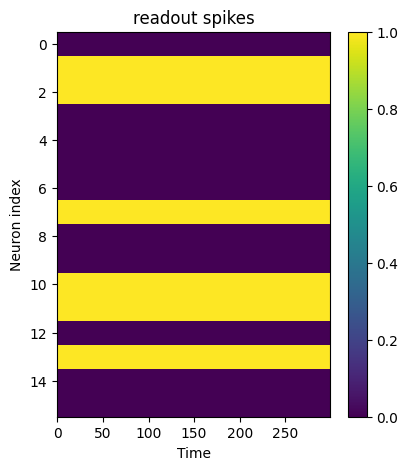

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(np.array(out).T, aspect='auto', interpolation='none'); plt.title('readout spikes'); plt.xlabel('Time'); plt.ylabel('Neuron index'); plt.colorbar()